In [1]:
! pip install pandas numpy scipy matplotlib seaborn scikit-learn mygene jupyter

  Using cached certifi-2025.4.26-py3-none-any.whl.metadata (2.5 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached urllib3-2.4.0-py3-none-any.whl.metadata (6.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 4.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 2.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 2.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 2.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 1.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 2.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.0 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 1.8 MB/s eta 0:00:00a 0:00:01
Using cached idna-3.10-py3-none-any.whl (70 kB)
U

In [1]:
import pandas as pd
from scipy.stats import ttest_ind

# Load the data
df = pd.read_csv('GSE19804_series_matrix.txt', sep="\t", comment='!', index_col=0)

df = df.transpose()

# OPTIONAL: drop any columns not gene probes
# For example, keep only float columns (gene expression)
df = df.select_dtypes(include='float64')

# Step 1: Assign sample labels (first 60 = tumor, next 60 = normal)
labels = ['Tumor'] * 60 + ['Normal'] * 60
df['label'] = labels

# Step 2: Split data
tumor = df[df['label'] == 'Tumor'].drop(columns=['label'])
normal = df[df['label'] == 'Normal'].drop(columns=['label'])

# Step 3: Perform t-test for each gene
results = []
for gene in tumor.columns:
    stat, p = ttest_ind(tumor[gene], normal[gene])
    results.append((gene, stat, p))

# Step 4: Convert to DataFrame and sort by p-value
result_df = pd.DataFrame(results, columns=['Gene', 'T-statistic', 'P-value'])
result_df = result_df.sort_values('P-value')

# Show top 10 differentially expressed genes
print(result_df.head(10))


              Gene  T-statistic       P-value
26336  217046_s_at   -20.023918  9.296289e-40
25211  215918_s_at   -20.015457  9.662377e-40
11972  202524_s_at   -18.973455  1.204164e-37
37794    228540_at   -18.342796  2.387803e-36
39723    230469_at   -18.326222  2.584557e-36
48899    239650_at   -18.020563  1.120214e-35
3845    1557729_at   -17.851949  2.528399e-35
15654    206208_at   -17.714688  4.918132e-35
15655  206209_s_at   -17.377253  2.549939e-34
27056    217771_at    17.266428  4.391610e-34


In [2]:
import pandas as pd
import mygene

mg = mygene.MyGeneInfo()

# Convert probe list
probes = result_df['Gene'].tolist()
annotations = mg.querymany(probes, scopes='reporter', fields='symbol', species='human')

# Turn into DataFrame
annot_df = pd.DataFrame(annotations)

# Remove rows with no symbol
annot_df = annot_df[annot_df['symbol'].notna()]

# Map gene symbols back to your result_df
probe_to_symbol = dict(zip(annot_df['query'], annot_df['symbol']))
result_df['GeneSymbol'] = result_df['Gene'].map(probe_to_symbol)

# Drop rows with no gene symbol
result_df = result_df.dropna(subset=['GeneSymbol'])

print(result_df[['Gene', 'GeneSymbol', 'P-value']].head())


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
1861 input query terms found dup hits:	[('205200_at', 2), ('222738_at', 2), ('227452_at', 2), ('223531_x_at', 2), ('224448_s_at', 2), ('225
11130 input query terms found no hit:	['237390_at', '236383_at', '235642_at', '1557094_at', '243172_at', '242340_at', '238151_at', '238891


              Gene GeneSymbol       P-value
26336  217046_s_at       AGER  9.296289e-40
25211  215918_s_at     SPTBN1  9.662377e-40
11972  202524_s_at     SPOCK2  1.204164e-37
37794    228540_at        QKI  2.387803e-36
39723    230469_at      RTKN2  2.584557e-36


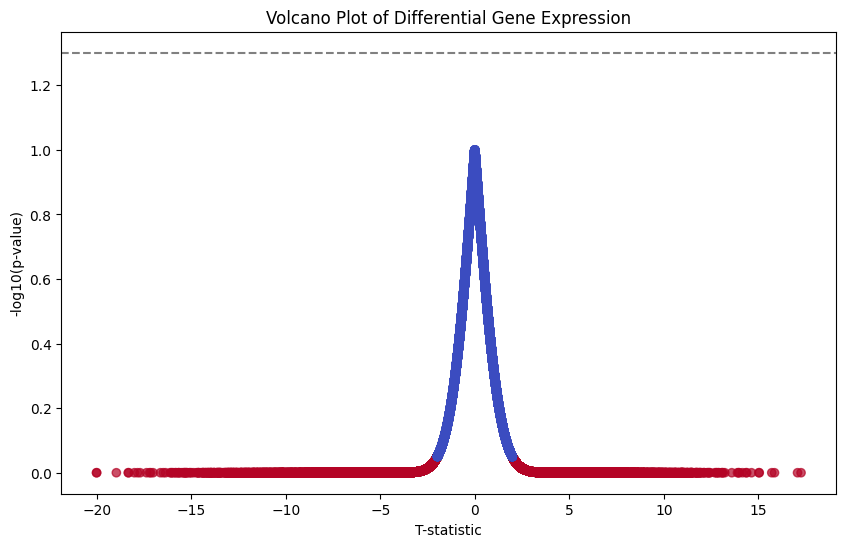

In [3]:

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.scatter(result_df['T-statistic'], result_df['P-value'],
            c=(result_df['P-value'] < 0.05), cmap='coolwarm', alpha=0.7)
plt.xlabel('T-statistic')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot of Differential Gene Expression')
plt.axhline(-np.log10(0.05), color='gray', linestyle='--')
plt.show()

In [8]:
# Only keep genes with p-value < 0.05
significant_genes = result_df[result_df['P-value'] < 0.05]

df2 = df[significant_genes["Gene"].values]
df2.shape

(120, 22337)

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Use top 50 genes
top_genes = result_df['Gene'].head(50)
X = df[top_genes]
y = df['label']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, pred))


Accuracy: 0.875


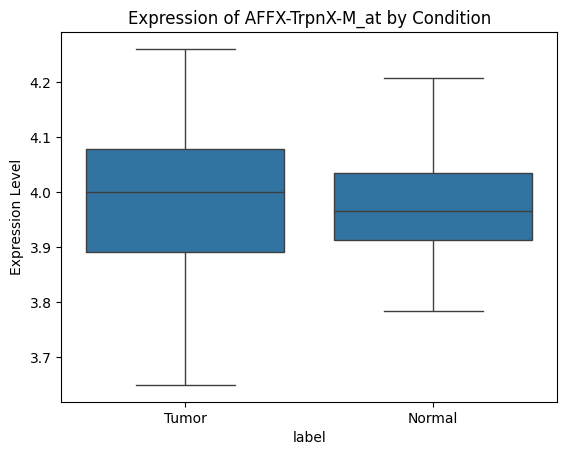

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='label', y=gene, data=df)
plt.title(f'Expression of {gene} by Condition')
plt.ylabel("Expression Level")
plt.show()

In [16]:
gene = '217046_s_at'
df[gene].describe()

count    120.000000
mean       8.733174
std        1.978091
min        5.751740
25%        6.747563
50%        9.237855
75%       10.635450
max       11.564400
Name: 217046_s_at, dtype: float64

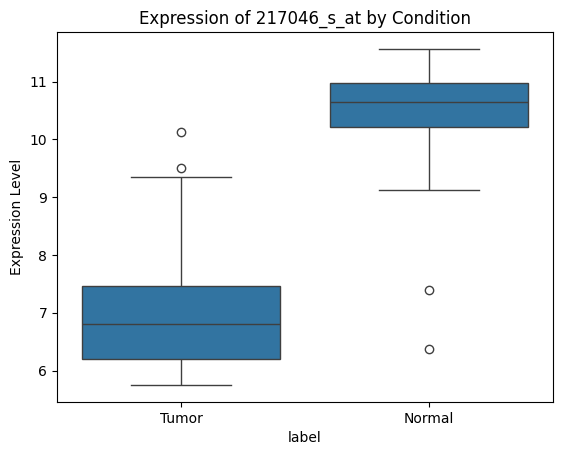

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='label', y=gene, data=df)
plt.title(f'Expression of {gene} by Condition')
plt.ylabel("Expression Level")
plt.show()


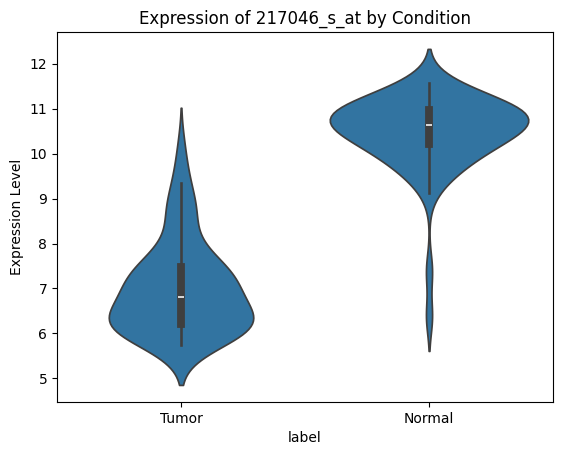

In [17]:
sns.violinplot(x='label', y=gene, data=df)
plt.title(f'Expression of {gene} by Condition')
plt.ylabel("Expression Level")
plt.show()

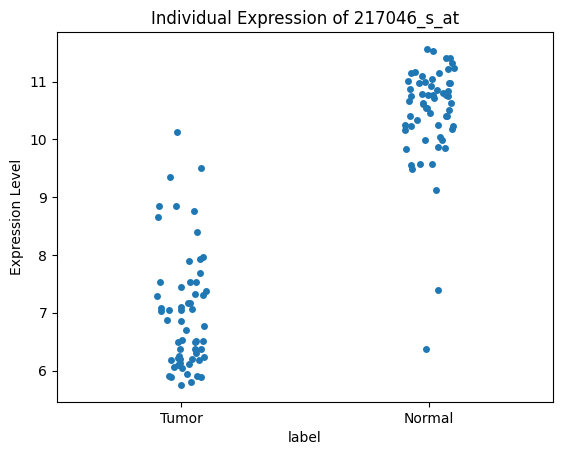

In [18]:
sns.stripplot(x='label', y=gene, data=df, jitter=True)
plt.title(f'Individual Expression of {gene}')
plt.ylabel("Expression Level")
plt.show()

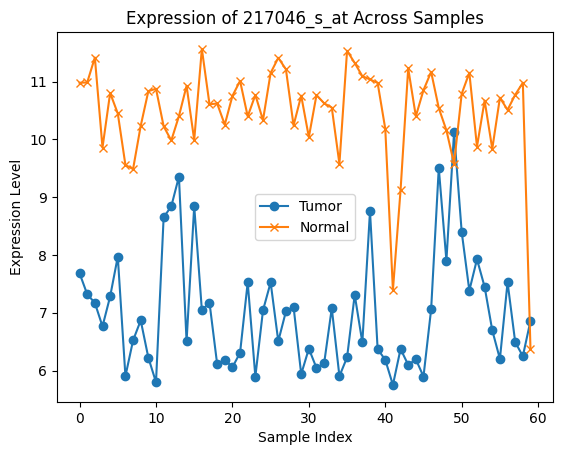

In [ ]:
import numpy as np

# Split data
tumor_vals = df[df['label'] == 'Tumor'][gene].values
normal_vals = df[df['label'] == 'Normal'][gene].values

plt.plot(np.arange(len(tumor_vals)), tumor_vals, label='Tumor', marker='o')
plt.plot(np.arange(len(normal_vals)), normal_vals, label='Normal', marker='x')
plt.title(f"Expression of {gene} Across Samples")
plt.xlabel("Sample Index")
plt.ylabel("Expression Level")
plt.legend()
plt.show()

### Statistical Test: t-test

In [20]:
from scipy.stats import ttest_ind

tumor_vals = df[df['label'] == 'Tumor'][gene]
normal_vals = df[df['label'] == 'Normal'][gene]

t_stat, p_value = ttest_ind(tumor_vals, normal_vals, equal_var=False)
print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.3e}")

T-statistic: -20.024, P-value: 2.636e-39


### Histogram by Group

<Axes: xlabel='217046_s_at', ylabel='Density'>

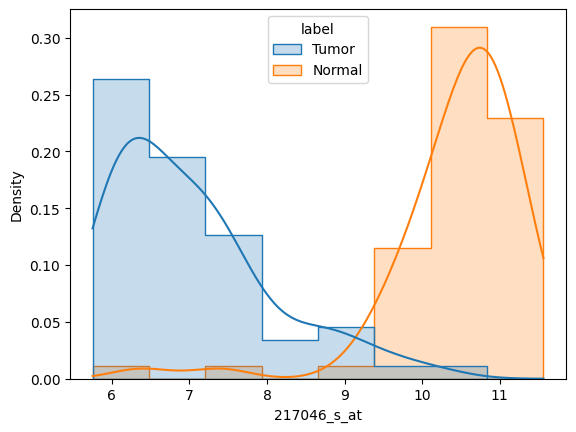

In [21]:
sns.histplot(data=df, x=gene, hue='label', kde=True, element="step", stat="density")


## Cumulative Distribution Function (CDF)

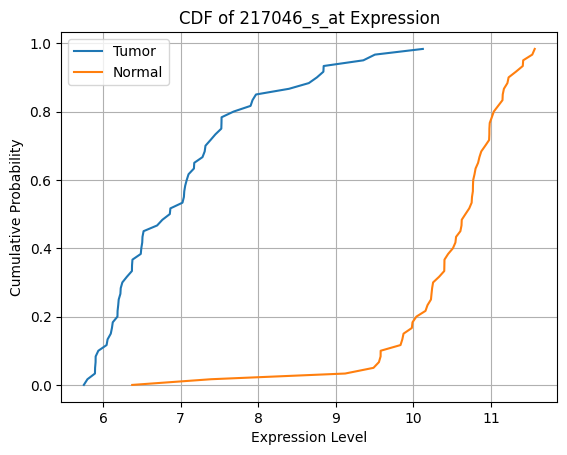

In [22]:
import numpy as np

def plot_cdf(values, label):
    sorted_vals = np.sort(values)
    y = np.arange(len(sorted_vals)) / float(len(sorted_vals))
    plt.plot(sorted_vals, y, label=label)

plot_cdf(tumor_vals, "Tumor")
plot_cdf(normal_vals, "Normal")
plt.title(f"CDF of {gene} Expression")
plt.xlabel("Expression Level")
plt.ylabel("Cumulative Probability")
plt.legend()
plt.grid(True)
plt.show()


##  Effect Size: Cohen’s d

In [23]:
def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    s1, s2 = group1.std(), group2.std()
    pooled_sd = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
    return (group1.mean() - group2.mean()) / pooled_sd

d = cohens_d(tumor_vals, normal_vals)
print(f"Cohen's d: {d:.2f}")


Cohen's d: -3.66


### Z-score Normalization Plot


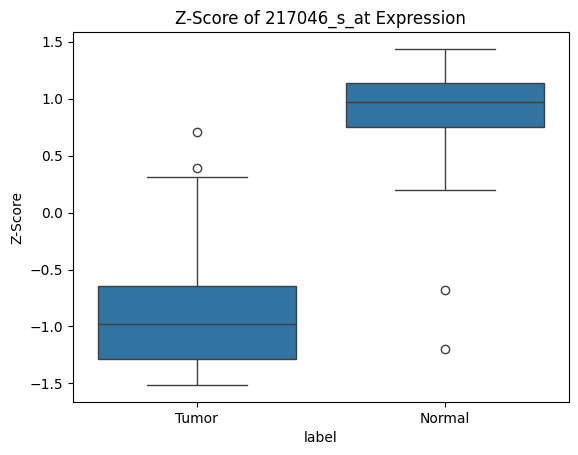

In [24]:
from scipy.stats import zscore

df['z_score'] = zscore(df[gene])

sns.boxplot(x='label', y='z_score', data=df)
plt.title(f"Z-Score of {gene} Expression")
plt.ylabel("Z-Score")
plt.show()


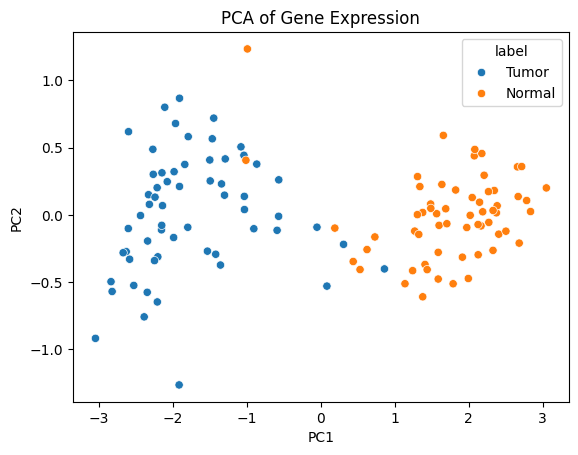

In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

genes = ['217046_s_at', '215918_s_at', '202524_s_at', '228540_at']
X = df[genes].values
y = df['label'].values

# Normalize
X_scaled = StandardScaler().fit_transform(X)

# PCA
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

# Plot
pca_df = pd.DataFrame(data=components, columns=['PC1', 'PC2'])
pca_df['label'] = y

sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='label')
plt.title('PCA of Gene Expression')
plt.show()


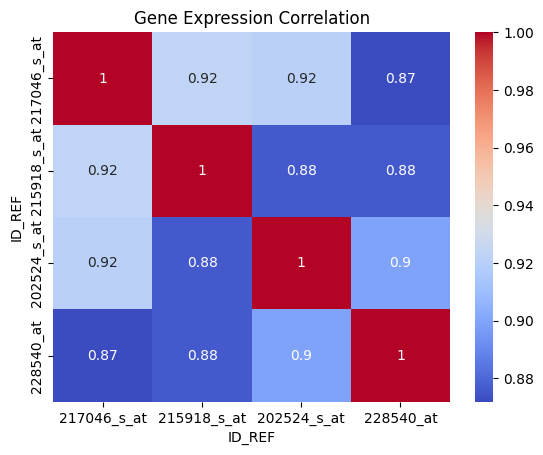

In [27]:
genes = ['217046_s_at', '215918_s_at', '202524_s_at', '228540_at']
corr = df[genes].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Gene Expression Correlation")
plt.show()


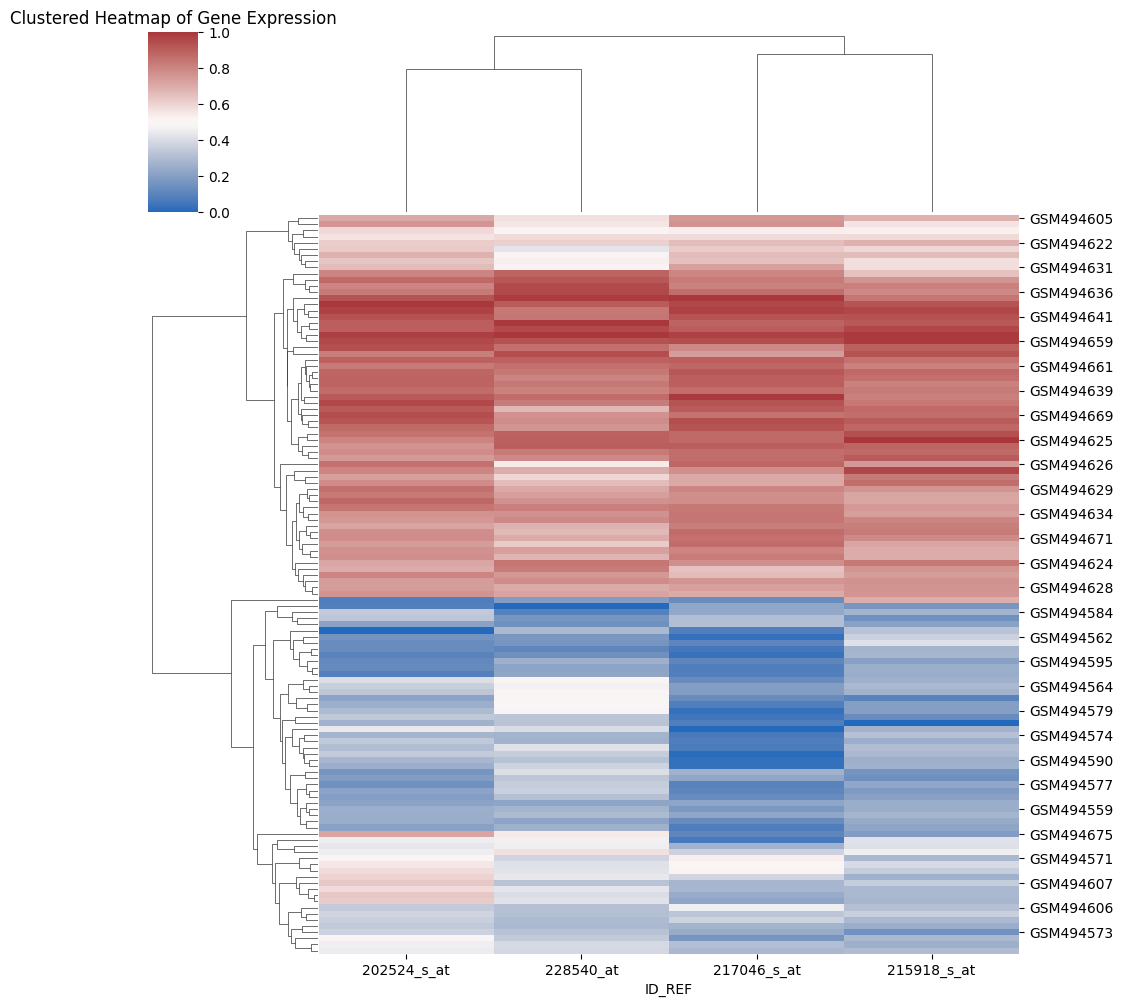

In [28]:
sns.clustermap(df[genes], cmap="vlag", standard_scale=1)
plt.title("Clustered Heatmap of Gene Expression")
plt.show()
